In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import json
from matplotlib.colors import LinearSegmentedColormap
import torchvision
from torchvision import models
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
data_dir = '/kaggle/input/malimg-dataset/malimg/train'

# List all subdirectories (classes) in the root directory
classes = [d.name for d in os.scandir(data_dir) if d.is_dir()]

print(classes)

['Lolyda.AA3', 'Malex.gen!J', 'C2LOP.gen!g', 'Wintrim.BX', 'Instantaccess', 'Obfuscator.AD', 'Allaple.L', 'VB.AT', 'Lolyda.AA2', 'Lolyda.AA1', 'Adialer.C', 'Dontovo.A', 'Agent.FYI', 'Skintrim.N', 'Alueron.gen!J', 'Dialplatform.B', 'Autorun.K', 'Yuner.A', 'Allaple.A', 'Swizzor.gen!E', 'Rbot!gen', 'C2LOP.P', 'Swizzor.gen!I', 'Fakerean', 'Lolyda.AT']


In [5]:
# Load and preprocess the Malimg dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder('/kaggle/input/malimg-dataset/malimg/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder('/kaggle/input/malimg-dataset/malimg/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

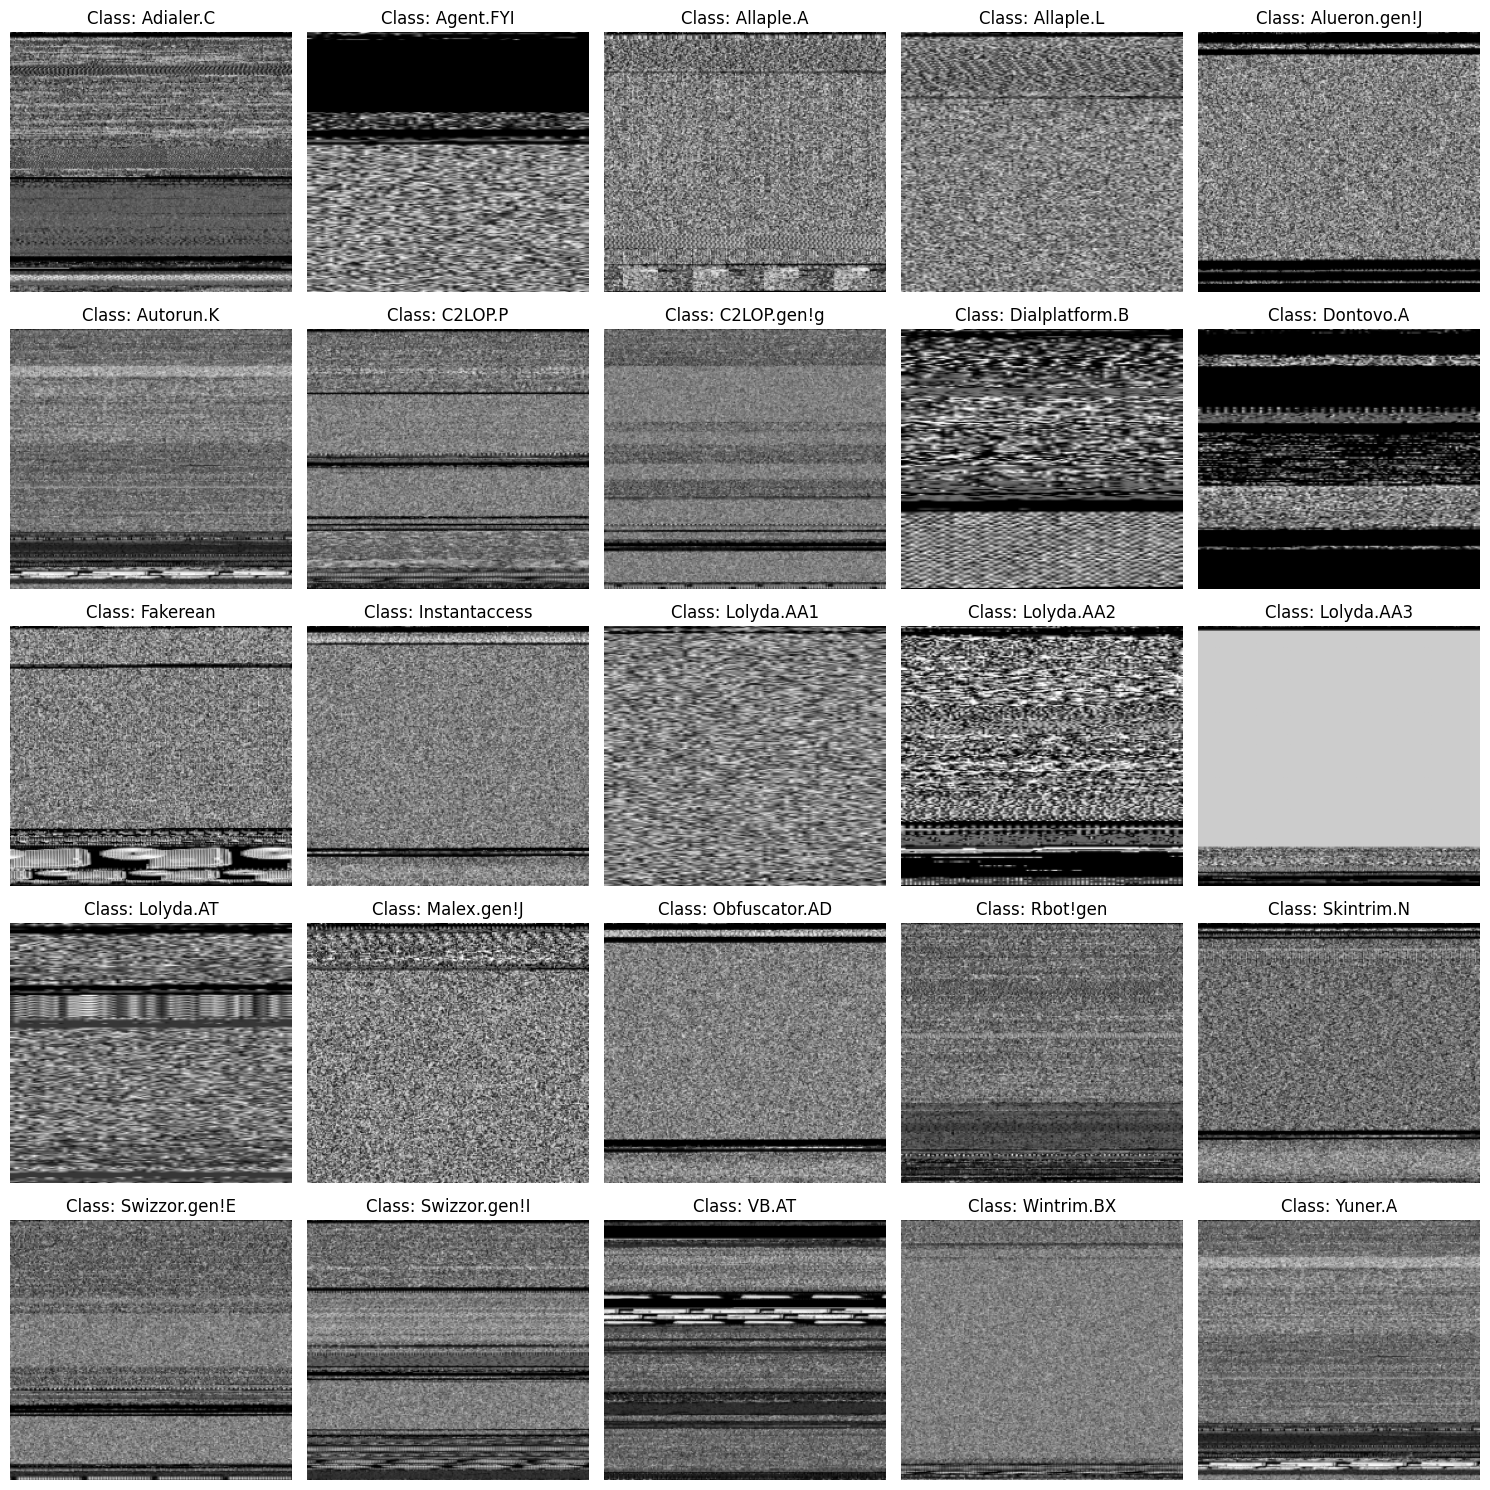

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show one sample image from each class in a 5x5 grid
def show_samples(dataset):
    classes = dataset.classes
    class_indices = [dataset.class_to_idx[class_name] for class_name in classes]
    
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))

    for i, class_idx in enumerate(class_indices):
        # Choose one sample randomly from each class
        sample_idx = np.random.choice(np.where(np.array(dataset.targets) == class_idx)[0])
        img, label = dataset[sample_idx]
        
        row = i // 5
        col = i % 5

        axes[row, col].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[row, col].set_title(f'Class: {classes[label]}')
        axes[row, col].axis('off')
        axes[row, col].set_aspect('auto')  # Set aspect ratio to 'auto'

    plt.tight_layout()
    plt.show()

# Show one sample from each class in a 5x5 grid
show_samples(train_dataset)


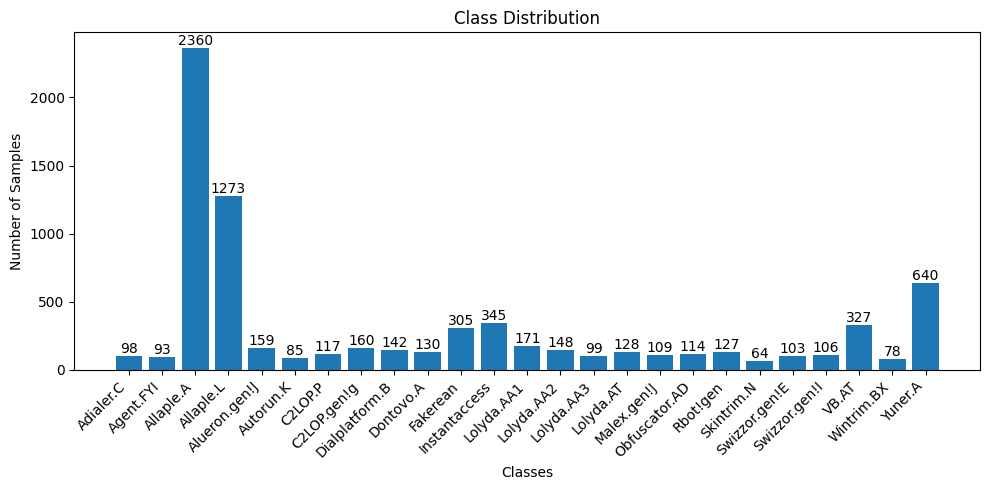

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show a sample image from each class and display the class distribution
def distribution(dataset, num_samples=1):
    classes = dataset.classes
    class_indices = [dataset.class_to_idx[class_name] for class_name in classes]
    
    # Create subplots for both sample images and class distribution
    fig, axes_distribution = plt.subplots(figsize=(10, 5))
    # Show class distribution histogram with numbers on top of bars
    class_counts = [np.sum(np.array(dataset.targets) == class_idx) for class_idx in class_indices]
    bars = axes_distribution.bar(classes, class_counts)
    
    for bar, count in zip(bars, class_counts):
        yval = bar.get_height()
        axes_distribution.text(bar.get_x() + bar.get_width()/2, yval, int(count), ha='center', va='bottom')

    axes_distribution.set_title('Class Distribution')
    axes_distribution.set_xlabel('Classes')
    axes_distribution.set_ylabel('Number of Samples')
    
    # Rotate x-labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Show one sample from each class and class distribution in the training dataset
distribution(train_dataset)


In [43]:
# Create the EfficientNetV2-S  model and moved it to the GPU
model = models.efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1").to(device)
num_classes = len(classes)
model.classifier = nn.Linear(model.classifier[1].in_features, num_classes).to(device)
# Defined loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 269MB/s]


In [44]:
# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = (np.array(all_labels) == np.array(all_preds)).mean()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/5, Loss: 0.1209, Test Accuracy: 0.9144
Epoch 2/5, Loss: 0.1980, Test Accuracy: 0.9639
Epoch 3/5, Loss: 0.0971, Test Accuracy: 0.9779
Epoch 4/5, Loss: 0.0429, Test Accuracy: 0.9596
Epoch 5/5, Loss: 0.0526, Test Accuracy: 0.9758


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

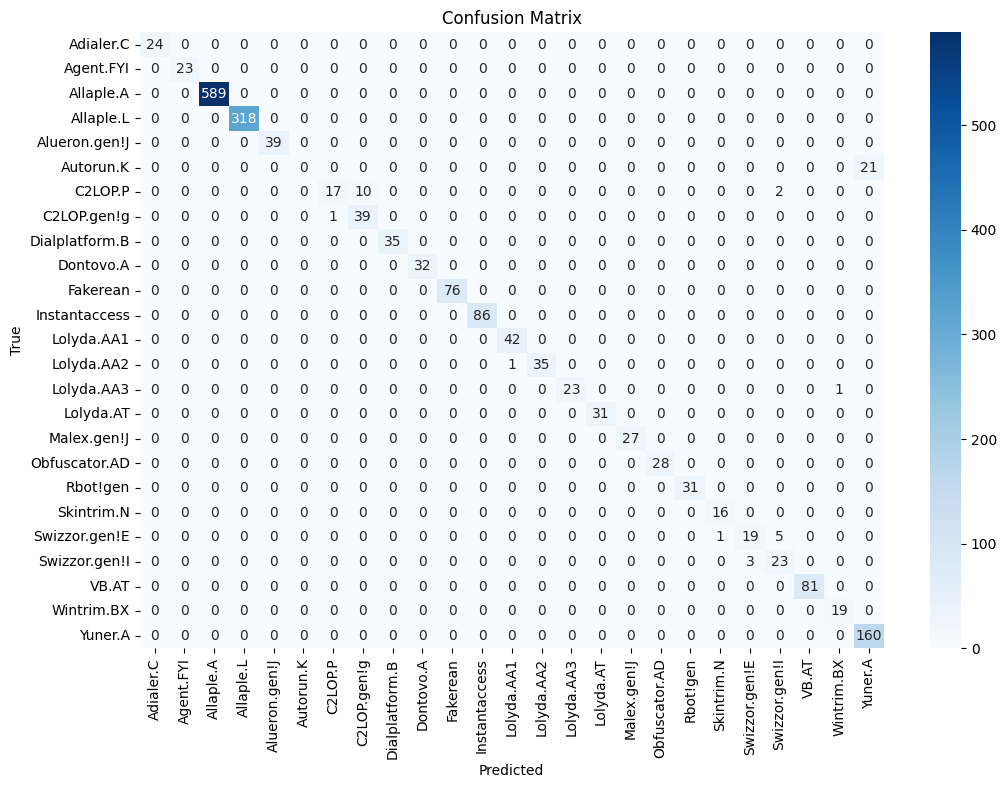

In [54]:

# Calculate and visualize the confusion matrix
conf_matrix = metrics.confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


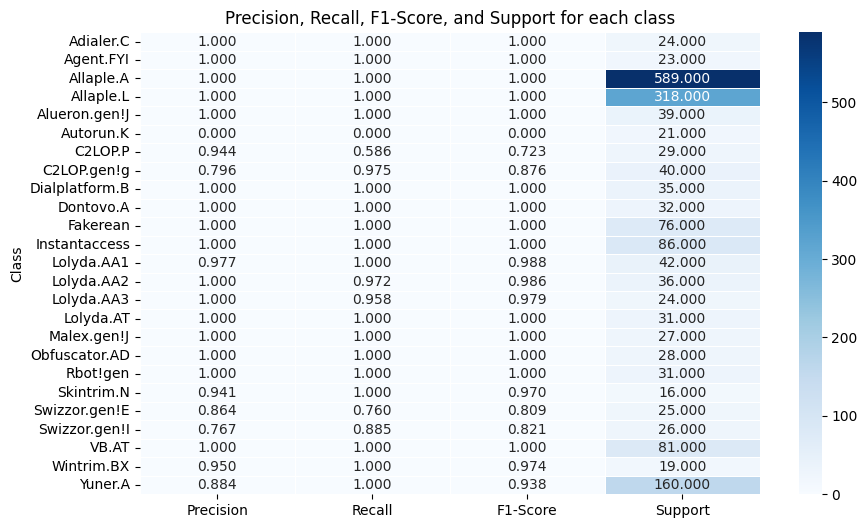

In [55]:
# Compute precision, recall, F1-score, and support for each class
precision, recall, fscore, support = metrics.precision_recall_fscore_support(all_labels, all_preds)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Class': train_dataset.classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': fscore,
    'Support': support
})

# Set the 'Class' column as the index for better visualization
results_df.set_index('Class', inplace=True)

# Plot the table with a colormap
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, cmap='Blues', fmt=".3f", linewidths=.5)
plt.title('Precision, Recall, F1-Score, and Support for each class')
plt.show()


In [56]:
import json

from torchvision import models

import shap

In [57]:

def normalize(image, channel_tolerance=0.1, device="cuda"):
    mean = torch.tensor([0.485, 0.456, 0.406], device=device)
    std = torch.tensor([0.229, 0.224, 0.225], device=device)

    if image.max() > 1:
        image /= 255
    # Transpose the channels to be the last dimension
    image = image.permute(0, 2, 3, 1)
    # Move the image tensor to the specified device
    image = image.to(device)
    # Check the number of channels with tolerance
    num_channels = image.shape[-1]
    expected_channels = 3
    if not (expected_channels * (1 - channel_tolerance) <= num_channels <= expected_channels * (1 + channel_tolerance)):
        print("Number of channels:", num_channels)
        raise ValueError("Input image must have 3 channels.")
    # Normalize each channel independently
    image = (image - mean) / std
    return image.permute(0, 3, 1, 2).float()

In [58]:
# Define the intermediate layer (6th layer in this case)
intermediate_layer =  model.features[5]

X, y = next(iter(test_loader))
X = normalize(X) 
X, y = X.to(device), y.to(device)

# Move the model to the same device
model.to(device)
print("")

Sample: 1014 True Label: 6 Allaple.L and Predicted Label: 6 Allaple.L


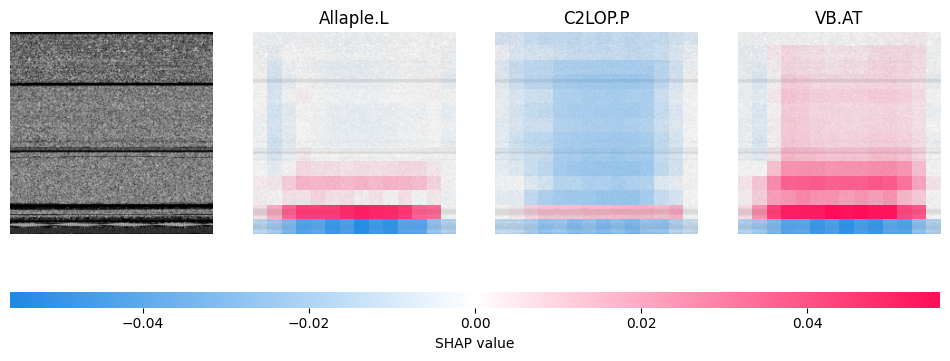

Sample: 1041 True Label: 6 Allaple.L and Predicted Label: 7 VB.AT


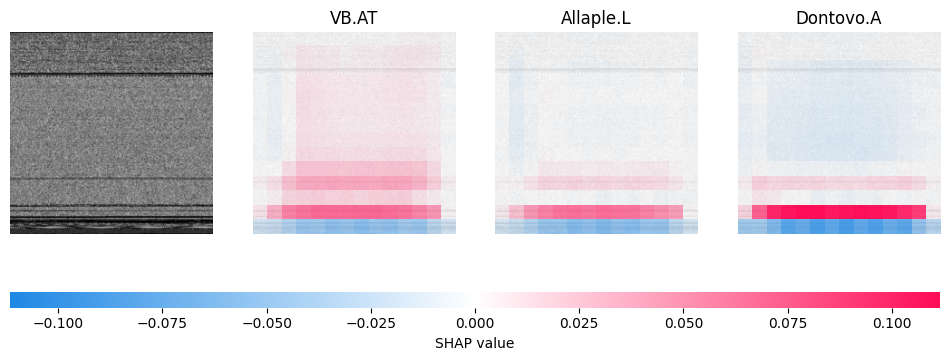

Sample: 1043 True Label: 7 VB.AT and Predicted Label: 7 VB.AT


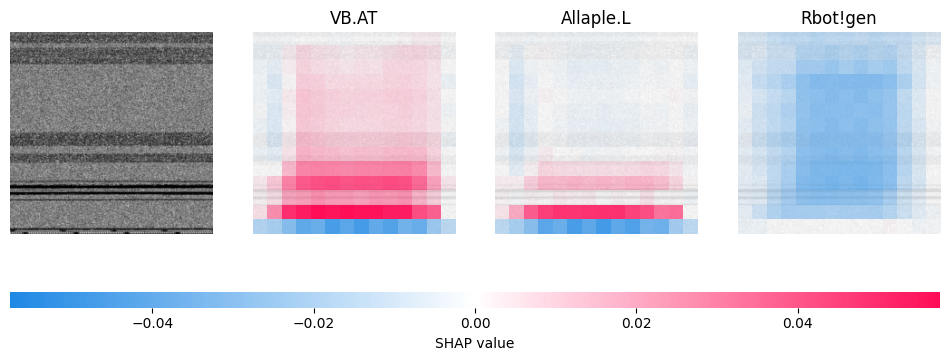

Sample: 1056 True Label: 7 VB.AT and Predicted Label: 6 Allaple.L


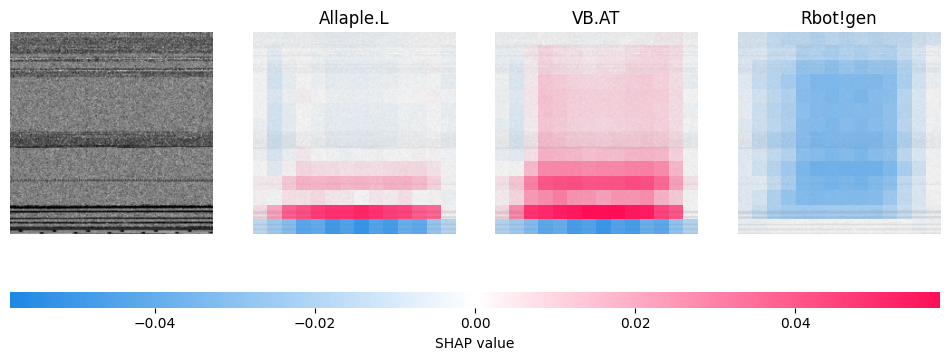

Sample: 1354 True Label: 13 Skintrim.N and Predicted Label: 13 Skintrim.N


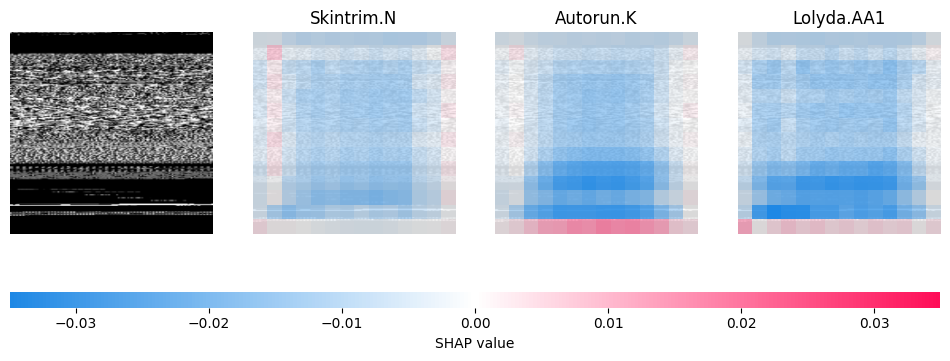

Sample: 1367 True Label: 13 Skintrim.N and Predicted Label: 12 Agent.FYI


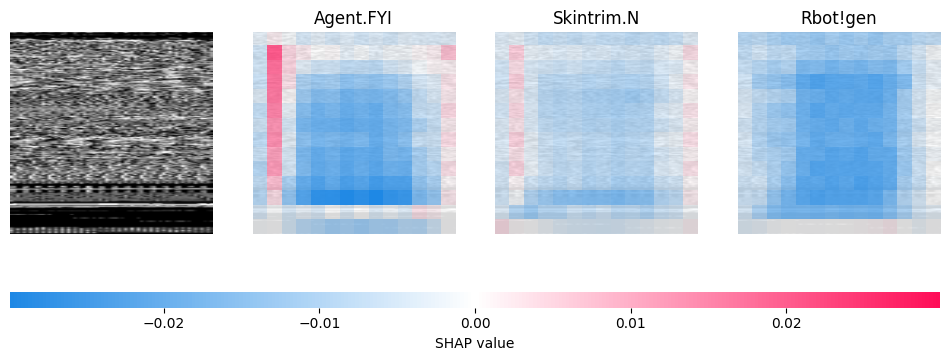

Sample: 1390 True Label: 14 Alueron.gen!J and Predicted Label: 14 Alueron.gen!J


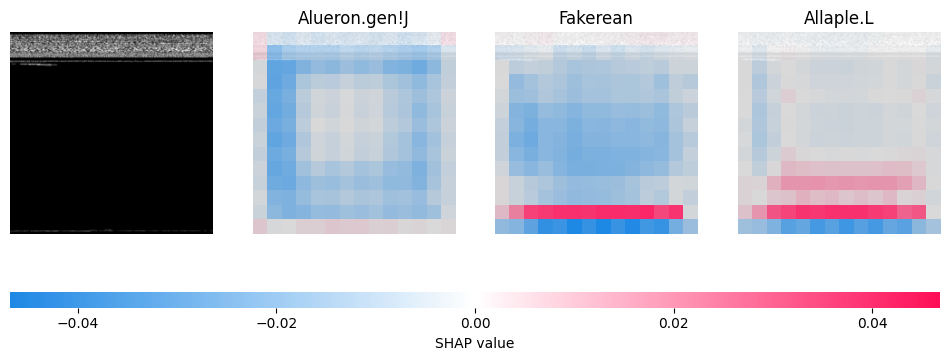

Sample: 1413 True Label: 14 Alueron.gen!J and Predicted Label: 23 Fakerean


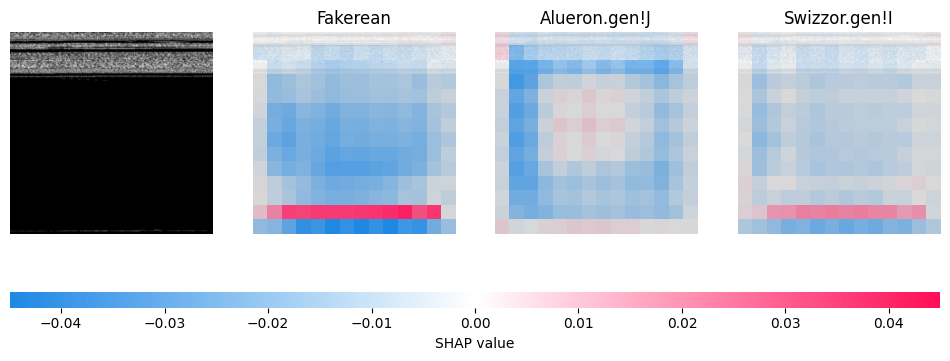

Sample: 1547 True Label: 20 Rbot!gen and Predicted Label: 20 Rbot!gen


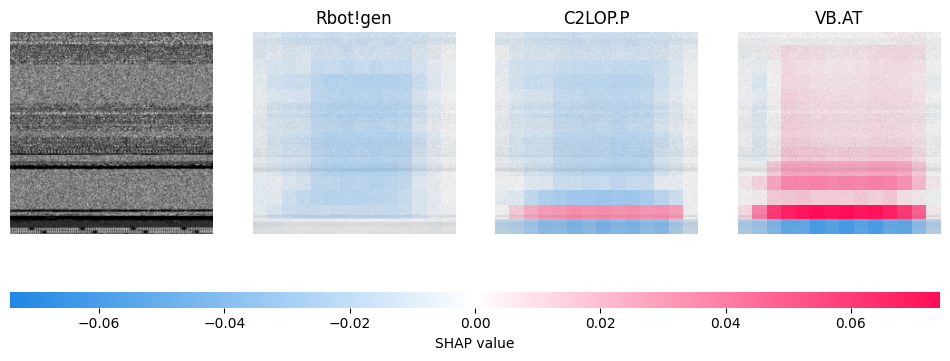

Sample: 1571 True Label: 20 Rbot!gen and Predicted Label: 21 C2LOP.P


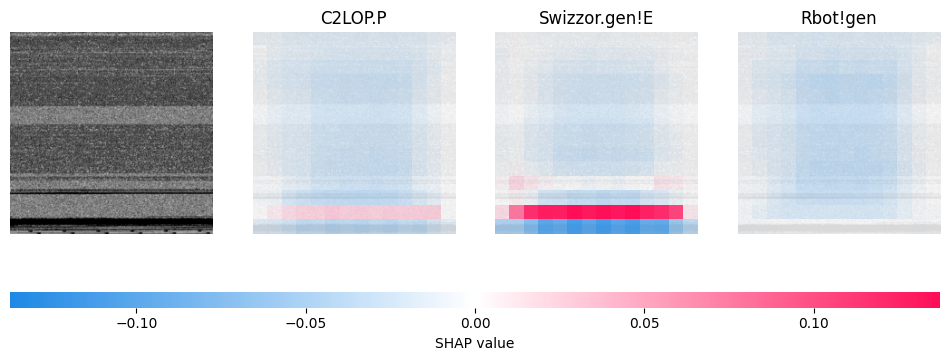

Sample: 1572 True Label: 21 C2LOP.P and Predicted Label: 21 C2LOP.P


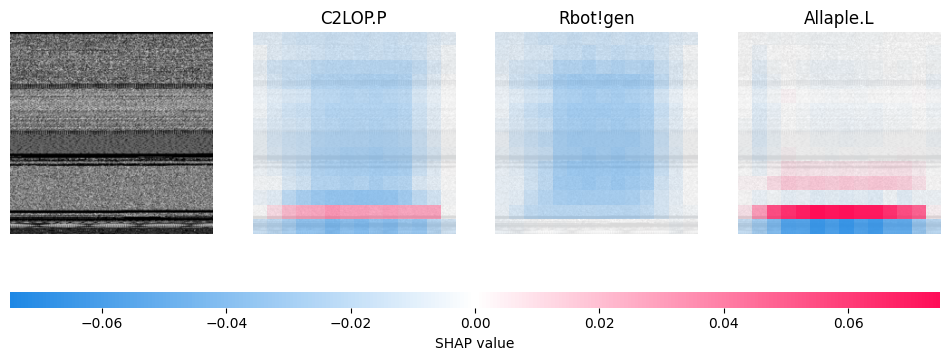

Sample: 1594 True Label: 21 C2LOP.P and Predicted Label: 20 Rbot!gen


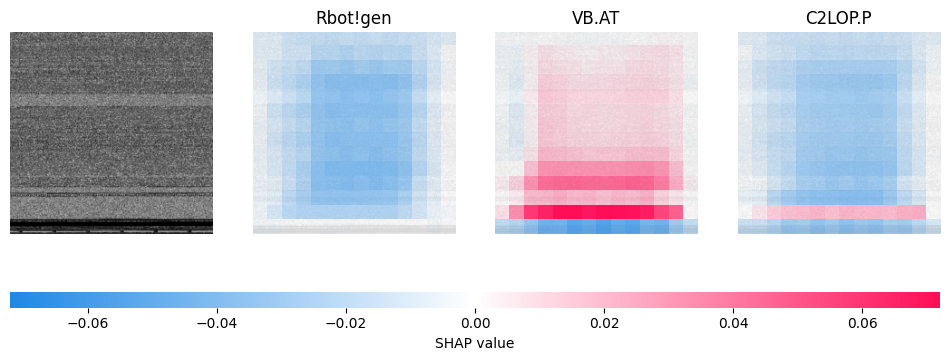

In [59]:
# Define the shap explainer with local smoothing
explainer = shap.GradientExplainer((model, intermediate_layer), normalize(X), local_smoothing=0.5)

# Create a dictionary to store one matched and one unmatched sample for each unique true label
samples_dict = {}

# Iterate over all samples to organize them by true label
for i in range(len(test_dataset)):
    true_label = all_labels[i]
    pred_label = all_preds[i]

    # Check if there is no matched sample for this true label yet
    if true_label not in samples_dict:
        # Check if the prediction is correct (matched)
        if true_label == pred_label:
            samples_dict[true_label] = {'matched': i}
    else:
        # Check if the prediction is incorrect (unmatched)
        if true_label != pred_label:
            samples_dict[true_label]['unmatched'] = i

# Process the selected samples
for true_label, sample_indices in samples_dict.items():
    # Check if both matched and unmatched samples are available for this true label
    if 'matched' in sample_indices and 'unmatched' in sample_indices:
        matched_sample = sample_indices['matched']
        unmatched_sample = sample_indices['unmatched']

        for sample in [matched_sample, unmatched_sample]:
            print("Sample:", sample, "True Label:", all_labels[sample], classes[all_labels[sample]], "and Predicted Label:", all_preds[sample], classes[all_preds[sample]])

            to_explain, label = test_dataset[sample]
            to_explain = to_explain.unsqueeze(0).to(device)  # Add batch dimension and move to the same device

            image_np = to_explain.cpu().numpy().squeeze().transpose((1, 2, 0))

            # Get SHAP values and indexes
            shap_values, indexes = explainer.shap_values(to_explain, ranked_outputs=3, nsamples=500)

            indexes_cpu = indexes.cpu()
            # Get the names for the classes
            index_names = np.vectorize(lambda x: classes[x])(indexes_cpu)

            shap_values_cpu = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
            # Transpose image dimensions if needed
            to_explain_transposed = np.transpose(to_explain.cpu().numpy(), (0, 2, 3, 1))

            # Plot the explanations
            shap.image_plot(shap_values_cpu, to_explain_transposed, index_names)


Sample: 1014 True Label: 6 Allaple.L and Predicted Label: 6 Allaple.L


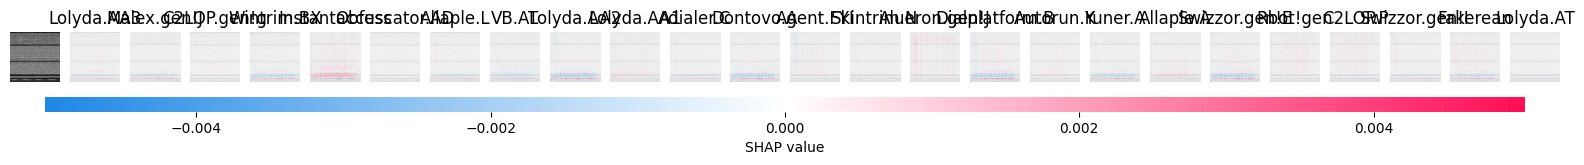

Sample: 1041 True Label: 6 Allaple.L and Predicted Label: 7 VB.AT


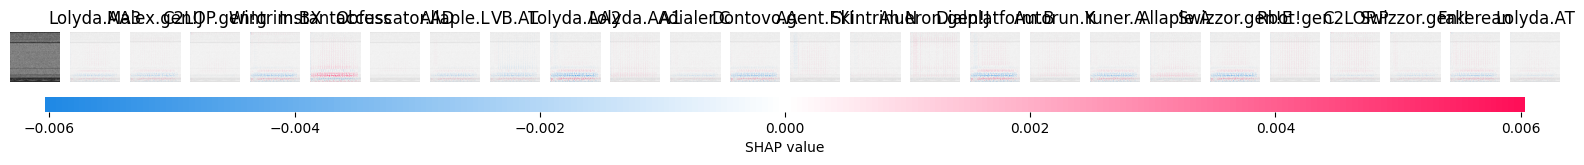

Sample: 1043 True Label: 7 VB.AT and Predicted Label: 7 VB.AT


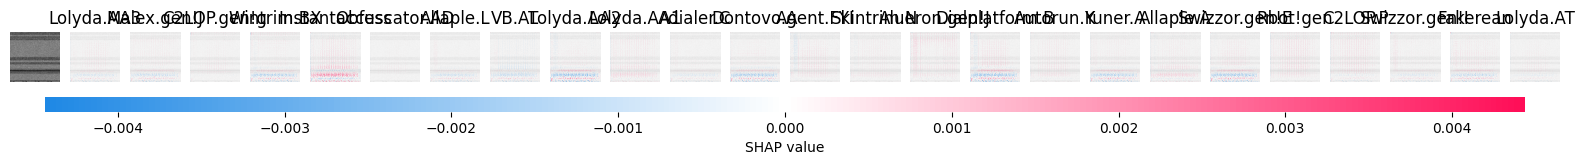

Sample: 1056 True Label: 7 VB.AT and Predicted Label: 6 Allaple.L


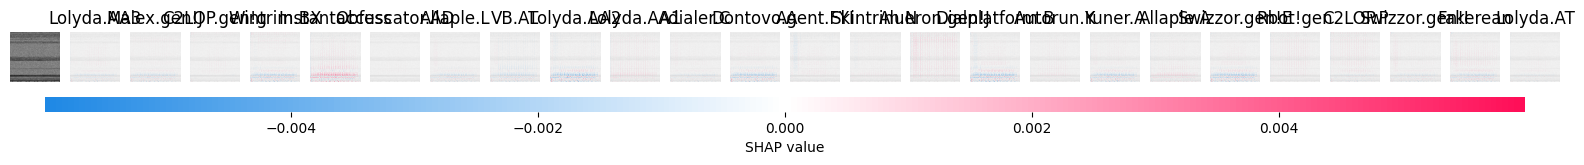

Sample: 1354 True Label: 13 Skintrim.N and Predicted Label: 13 Skintrim.N


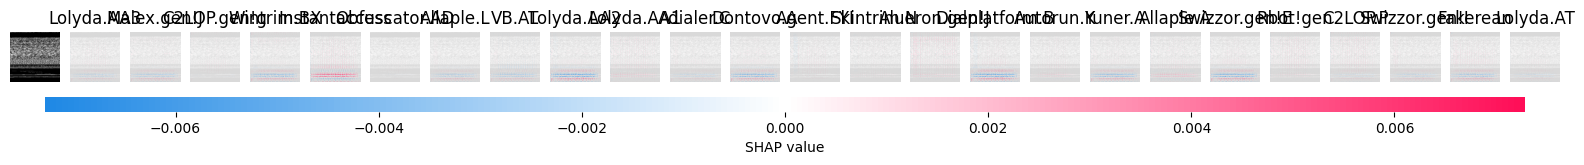

Sample: 1367 True Label: 13 Skintrim.N and Predicted Label: 12 Agent.FYI


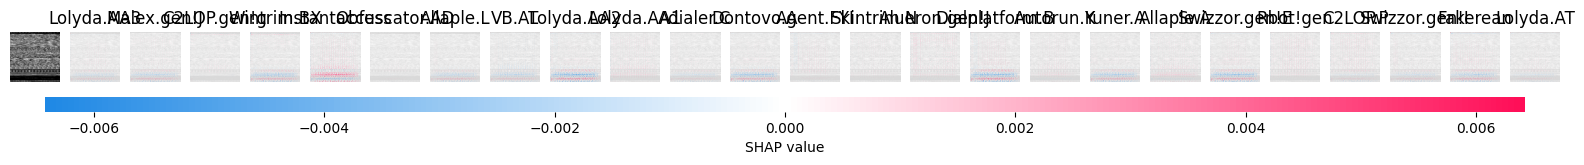

Sample: 1390 True Label: 14 Alueron.gen!J and Predicted Label: 14 Alueron.gen!J


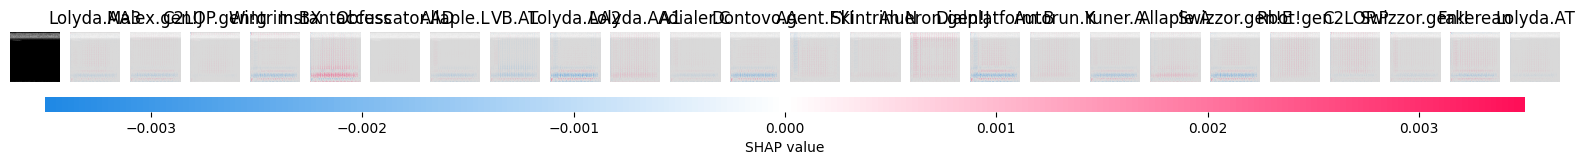

Sample: 1413 True Label: 14 Alueron.gen!J and Predicted Label: 23 Fakerean


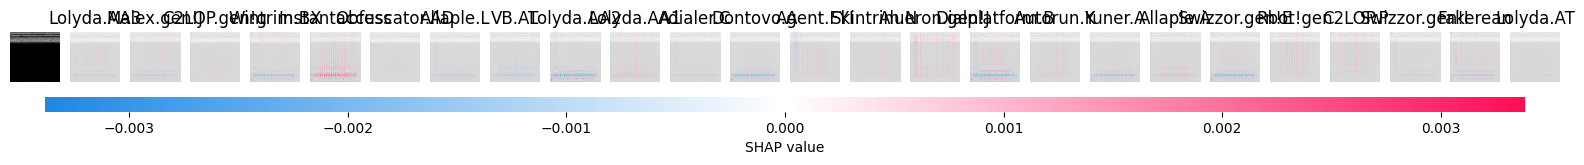

Sample: 1547 True Label: 20 Rbot!gen and Predicted Label: 20 Rbot!gen


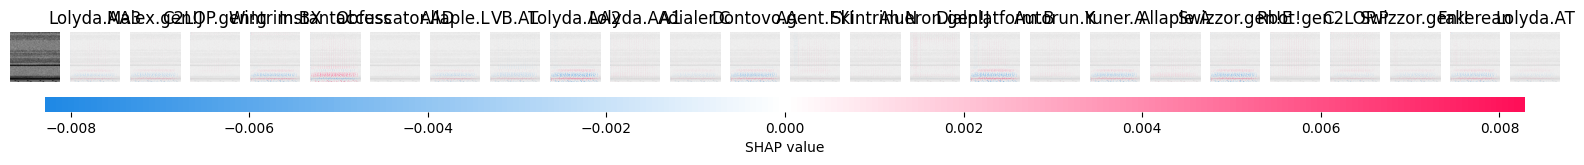

Sample: 1571 True Label: 20 Rbot!gen and Predicted Label: 21 C2LOP.P


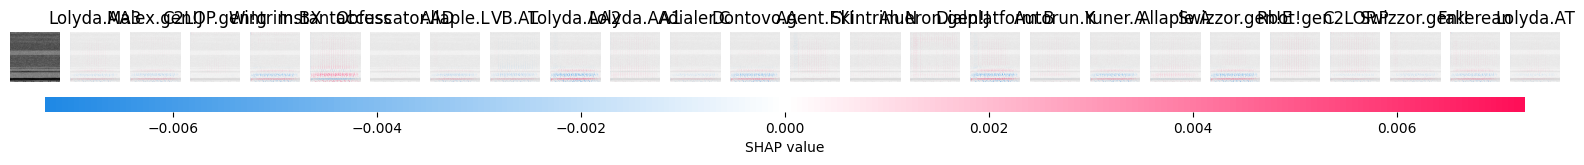

Sample: 1572 True Label: 21 C2LOP.P and Predicted Label: 21 C2LOP.P


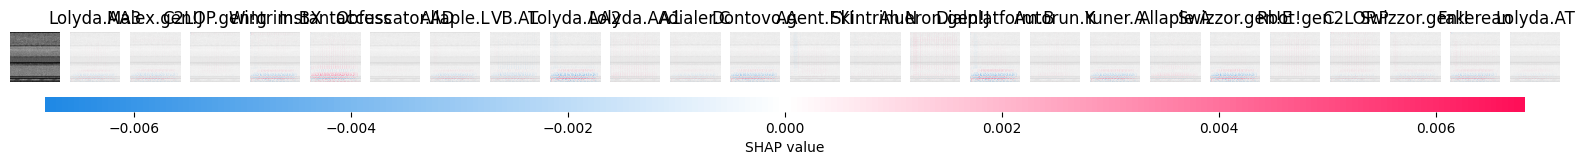

Sample: 1594 True Label: 21 C2LOP.P and Predicted Label: 20 Rbot!gen


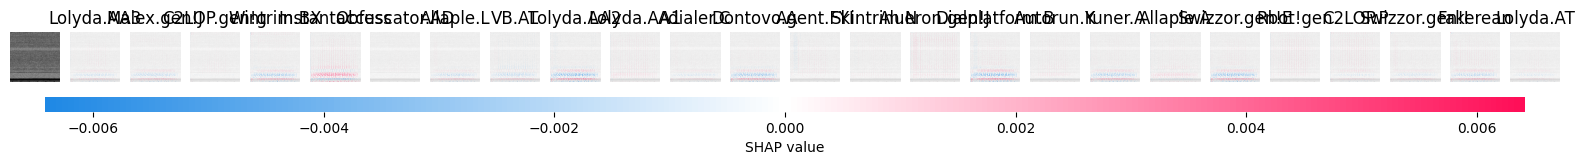

In [60]:
# Define the shap explainer with local smoothing
explainer = shap.GradientExplainer(model, normalize(X), local_smoothing=0.5)

# Create a dictionary to store one matched and one unmatched sample for each unique true label
samples_dict = {}

# Iterate over all samples to organize them by true label
for i in range(len(test_dataset)):
    true_label = all_labels[i]
    pred_label = all_preds[i]

    # Check if there is no matched sample for this true label yet
    if true_label not in samples_dict:
        # Check if the prediction is correct (matched)
        if true_label == pred_label:
            samples_dict[true_label] = {'matched': i}
    else:
        # Check if the prediction is incorrect (unmatched)
        if true_label != pred_label:
            samples_dict[true_label]['unmatched'] = i



# Process the selected samples
for true_label, sample_indices in samples_dict.items():
    # Check if both matched and unmatched samples are available for this true label
    if 'matched' in sample_indices and 'unmatched' in sample_indices:
        matched_sample = sample_indices['matched']
        unmatched_sample = sample_indices['unmatched']

        for sample in [matched_sample, unmatched_sample]:
            print("Sample:", sample, "True Label:", all_labels[sample], classes[all_labels[sample]], "and Predicted Label:", all_preds[sample], classes[all_preds[sample]])

            # Find the index of a sample with the current label
            sample_index = next(i for i, l in enumerate(all_labels) if l == label)

            to_explain, true_label = test_dataset[sample]
            to_explain = to_explain.unsqueeze(0).to(device)  # Add batch dimension and move to the same device

            # Get SHAP values and indexes
            shap_values = explainer.shap_values(to_explain, nsamples=200)

            shap_values_cpu = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
            # Transpose image dimensions if needed
            to_explain_transposed = np.transpose(to_explain.cpu().numpy(), (0, 2, 3, 1))

            # Plot the explanations
            shap.image_plot(shap_values_cpu, to_explain_transposed, classes)
